## 1. データセット <a class="anchor" id="first-bullet"></a>

In [51]:
# パッケージをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from scipy import signal
from scipy.stats import entropy

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

In [52]:
result = pd.read_csv("songs_normalize.csv")

# データセットを表示
result

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Jonas Brothers,Sucker,181026,False,2019,79,0.842,0.734,1,-5.065,0,0.0588,0.0427,0.000000,0.1060,0.952,137.958,pop
1996,Taylor Swift,Cruel Summer,178426,False,2019,78,0.552,0.702,9,-5.707,1,0.1570,0.1170,0.000021,0.1050,0.564,169.994,pop
1997,Blanco Brown,The Git Up,200593,False,2019,69,0.847,0.678,9,-8.635,1,0.1090,0.0669,0.000000,0.2740,0.811,97.984,"hip hop, country"
1998,Sam Smith,Dancing With A Stranger (with Normani),171029,False,2019,75,0.741,0.520,8,-7.513,1,0.0656,0.4500,0.000002,0.2220,0.347,102.998,pop


<h2 align=> 2. 新しいデータフレームの作成 </h2> <a class="anchor" id="second-bullet"></a>

In [53]:
# 'duration_ms'列をミリ秒から分に変換
result["duration_min"] = result["duration_ms"] / 60000.0

note_dict = {
    0: "C",
    1: "C#",
    2: "D",
    3: "D#",
    4: "E",
    5: "F",
    6: "F#",
    7: "G",
    8: "G#",
    9: "A",
    10: "A#",
    11: "B",
}

mode_dict = {1:"major", 0:"minor"}

# 欠損があっても落ちないように map 後に fillna
result["key_note"] = result["key"].map(note_dict).fillna("Unknown")
if "mode" in result.columns:
    result["key_mode"] = result["mode"].map(mode_dict).fillna("unknown")
else:
    # データに mode が無いケースへの緩衝（全て major 扱い）
    result["key_mode"] = "major"
result["key_full"] = result["key_note"] + " " + result["key_mode"]

# 2-3) ジャンル整形（一次表示用：先頭ラベル）
genre_raw = result["genre"].fillna("").astype(str)
genre_first = genre_raw.str.split(",").str[0].str.strip().str.lower()
genre_first = genre_first.replace({"set()":"others", "":"others"})  # 欠損・異常値を others へ
result["genre_primary"] = genre_first

In [54]:

result_new = pd.DataFrame({
    "artist": result["artist"],
    "song": result["song"],
    "duration [min]": result["duration_min"],
    "release year": result["year"],
    "key_full": result["key_full"],
    "tempo [bpm]": result["tempo"],
    "genre_primary": result["genre_primary"],
    # 解析用のオリジナル genre も保持（多ラベル用途）
    "genre_raw": genre_raw
})

# 保存（必要なら）
result_new.to_csv("Top_Hits_2000_2019_fixed.csv", index=False)

In [55]:
from collections import defaultdict

def multilabel_distribution(series_str, sep=","):
    """
    series_str: 文字列のジャンル列（例: "pop, rock"）
    各サンプルの総重み1.0をラベル数で等分配し、ラベルごとの出現重みを返す（確率分布ではない）。
    """
    counts = defaultdict(float)
    total_weight = 0.0
    for s in series_str.fillna(""):
        labels = [t.strip().lower() for t in str(s).split(sep) if t.strip() != "" and t.strip().lower() != "set()"]
        if len(labels) == 0:
            labels = ["others"]
        w = 1.0 / len(labels)
        for g in labels:
            counts[g] += w
        total_weight += 1.0
    # 確率分布（和=1）へ正規化
    if total_weight == 0:
        return pd.Series(dtype=float)
    prob = {k: v / total_weight for k, v in counts.items()}
    return pd.Series(prob).sort_values(ascending=False)

def shannon_diversity_fixed_support(p0: pd.Series, p1: pd.Series, support=None, base=2):
    """
    p0, p1: それぞれの確率分布（pd.Series, index=カテゴリ, values=確率）
    support: 比較時のカテゴリ集合（None の場合は union）
    戻り値: (H0, H1, change_ratio)
    """
    if support is None:
        support = sorted(set(p0.index) | set(p1.index))
    v0 = np.array([p0.get(k, 0.0) for k in support], dtype=float)
    v1 = np.array([p1.get(k, 0.0) for k in support], dtype=float)
    H0 = entropy(v0, base=base) if v0.sum() > 0 else np.nan
    H1 = entropy(v1, base=base) if v1.sum() > 0 else np.nan
    change = (H1 - H0) / H0 * 100.0 if (H0 is not None and H0 != 0 and not np.isnan(H0)) else np.nan
    return H0, H1, change, support

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    sx, sy = np.var(x, ddof=1), np.var(y, ddof=1)
    # Welch型の pooled SD
    s_p = np.sqrt(((nx-1)*sx + (ny-1)*sy) / (nx + ny - 2))
    if s_p == 0:
        return np.nan
    return (np.mean(y) - np.mean(x)) / s_p

def kde_peaks_from_ax(ax_line, prominence_ratio=0.12, distance=10, topk=None):
    """
    seaborn histplot(kde=True) から得た line オブジェクト(ax.get_lines()[0])を渡し、
    prominence を相対値で指定してピークを返す。
    """
    x, y = ax_line.get_data()
    if len(x) == 0 or len(y) == 0:
        return []
    prom = max(y) * prominence_ratio
    peaks, prop = signal.find_peaks(y, prominence=prom, distance=distance)
    # 高さ順に並べ替え
    order = np.argsort(y[peaks])[::-1]
    peaks_sorted = peaks[order]
    if topk is not None:
        peaks_sorted = peaks_sorted[:topk]
    return [(x[i], y[i]) for i in peaks_sorted]


<h2> 3. パラメータ（テンポ、長さ、キー、ジャンル）の4パネルプロット </h2> <a class="anchor" id="third-bullet"></a>

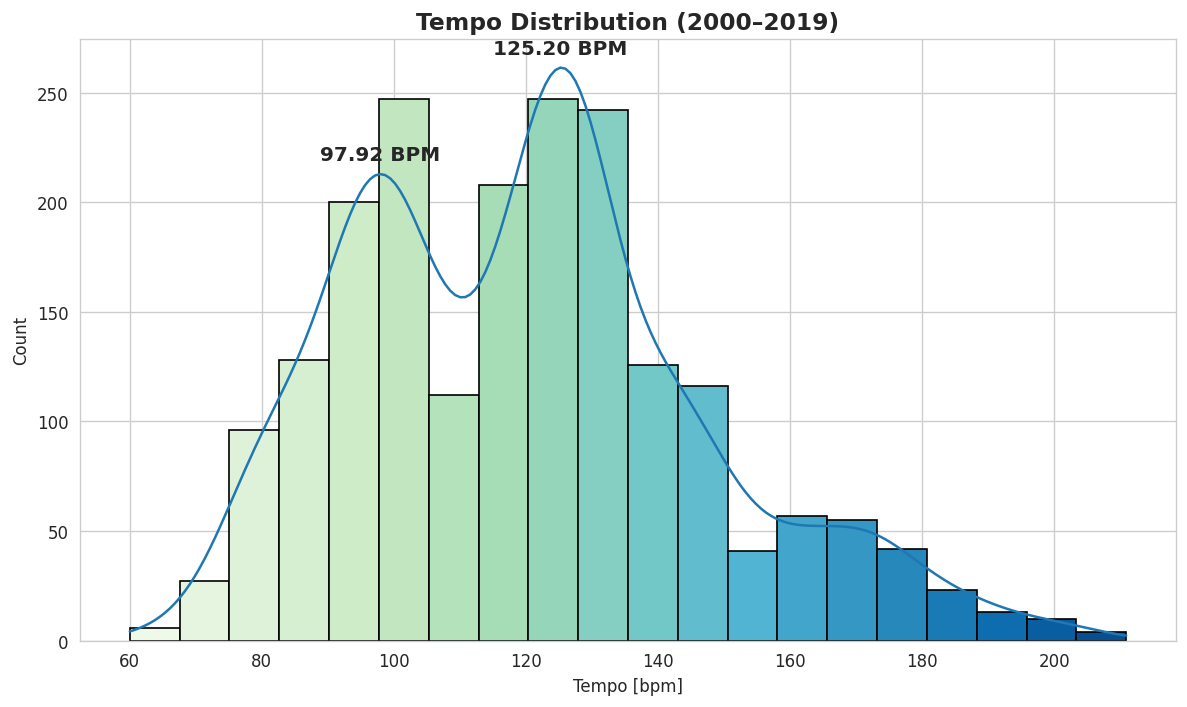

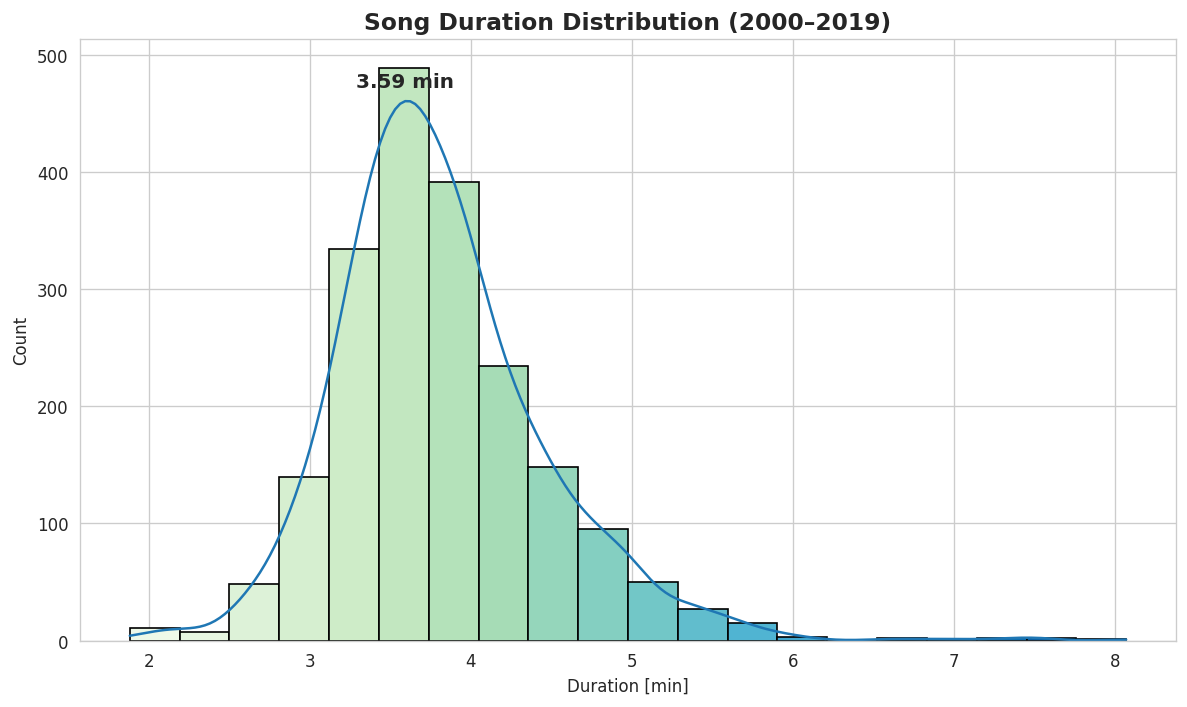

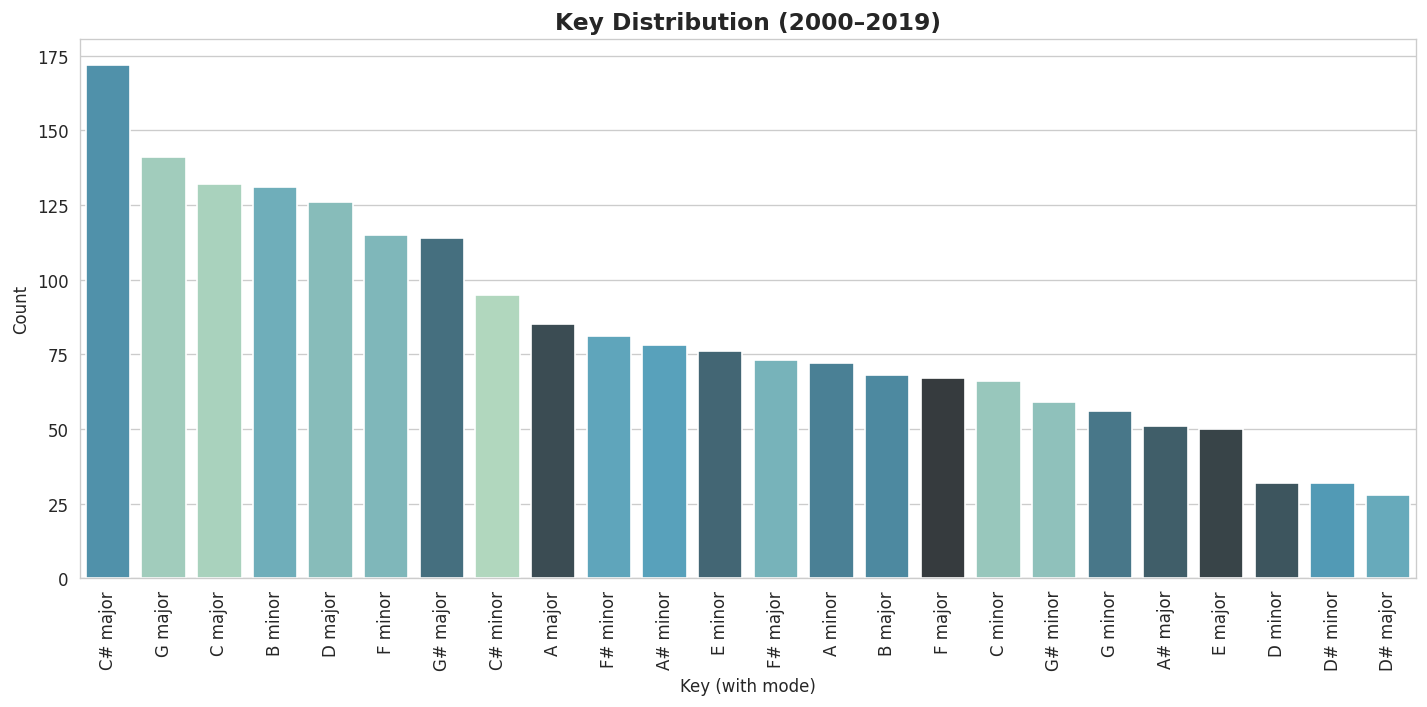

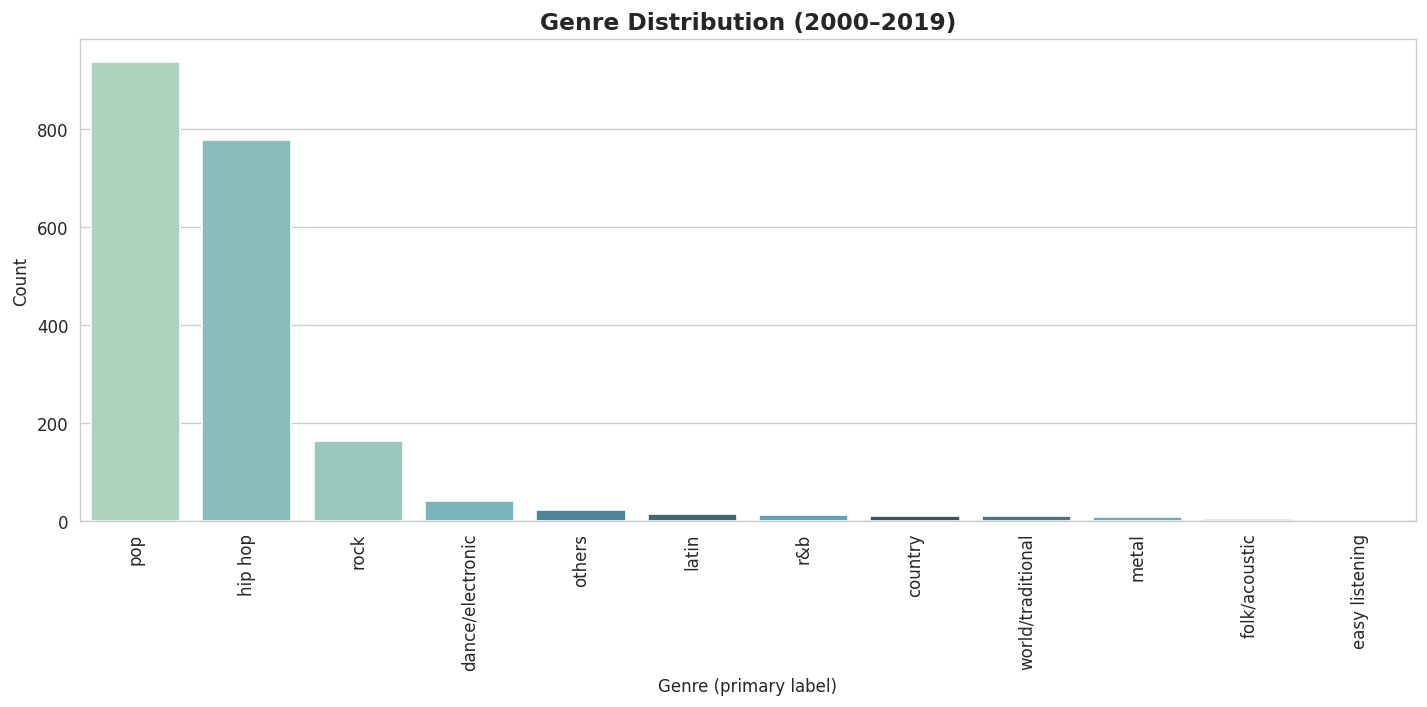

==== Summary (Peaks) ====
Popular tempos (top peaks): 125.20 BPM, 97.92 BPM
Popular durations (top peaks): 3.59 min



In [56]:
cm = sns.color_palette("GnBu", 20)

# テンポ分布
plt.figure(figsize=(10, 6))
p1 = sns.histplot(data=result_new, x="tempo [bpm]", bins=20, kde=True, edgecolor="k")
line1 = p1.get_lines()[0] if p1.get_lines() else None
tempo_peaks = kde_peaks_from_ax(line1, prominence_ratio=0.12, distance=8, topk=3) if line1 else []
for xpk, ypk in tempo_peaks:
    plt.annotate(f"{xpk:.2f} BPM", (xpk, ypk), xytext=(0,6), textcoords="offset points",
                 ha="center", va="bottom", fontsize=12, weight="bold")
plt.xlabel("Tempo [bpm]")
plt.ylabel("Count")
plt.title("Tempo Distribution (2000–2019)", fontsize=14, fontweight='bold')
for bin_, c in zip(p1.patches, cm):
    bin_.set_facecolor(c)
plt.tight_layout()
plt.show()

# 楽曲時間分布
plt.figure(figsize=(10, 6))
p2 = sns.histplot(data=result_new, x="duration [min]", bins=20, kde=True, edgecolor="k")
line2 = p2.get_lines()[0] if p2.get_lines() else None
dur_peaks = kde_peaks_from_ax(line2, prominence_ratio=0.12, distance=8, topk=2) if line2 else []
for xpk, ypk in dur_peaks:
    plt.annotate(f"{xpk:.2f} min", (xpk, ypk), xytext=(0,6), textcoords="offset points",
                 ha="center", va="bottom", fontsize=12, weight="bold")
plt.xlabel("Duration [min]")
plt.ylabel("Count")
plt.title("Song Duration Distribution (2000–2019)", fontsize=14, fontweight='bold')
for bin_, c in zip(p2.patches, cm):
    bin_.set_facecolor(c)
plt.tight_layout()
plt.show()

# キー分布（長短調込み）
plt.figure(figsize=(12, 6))
key_order = result_new["key_full"].value_counts().index.tolist()
sns.countplot(data=result_new, x="key_full", hue="key_full",
              order=key_order, palette="GnBu_d", legend=False)
plt.xlabel("Key (with mode)")
plt.ylabel("Count")
plt.title("Key Distribution (2000–2019)", fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ジャンル分布（一次可視化は先頭ラベル）
plt.figure(figsize=(12, 6))
genre_order = result_new["genre_primary"].value_counts().index.tolist()
sns.countplot(data=result_new, x="genre_primary", hue="genre_primary",
              order=genre_order, palette="GnBu_d", legend=False)
plt.xlabel("Genre (primary label)")
plt.ylabel("Count")
plt.title("Genre Distribution (2000–2019)", fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("==== Summary (Peaks) ====")
if tempo_peaks:
    tops = [f"{x:.2f} BPM" for x, _ in tempo_peaks[:2]]
    print("Popular tempos (top peaks):", ", ".join(tops))
if dur_peaks:
    tops = [f"{x:.2f} min" for x, _ in dur_peaks[:2]]
    print("Popular durations (top peaks):", ", ".join(tops))
print("=========================\n")

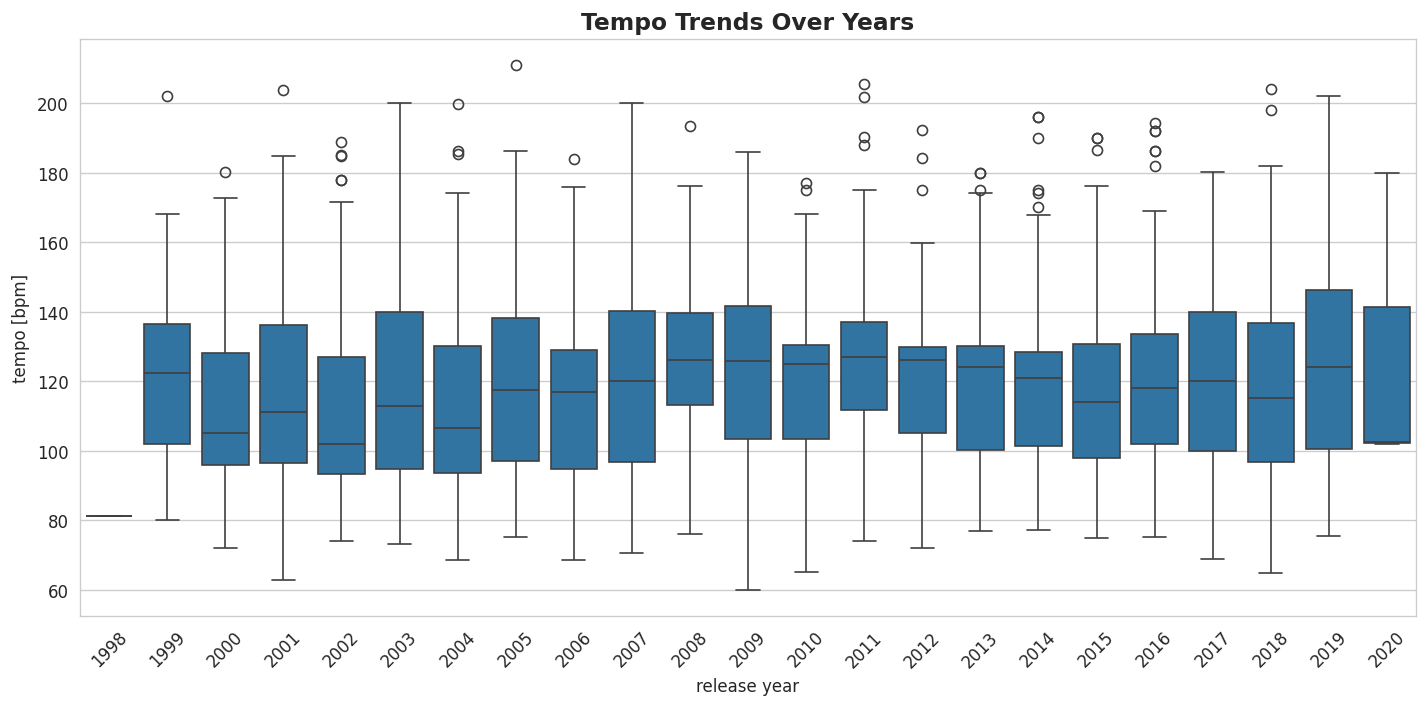

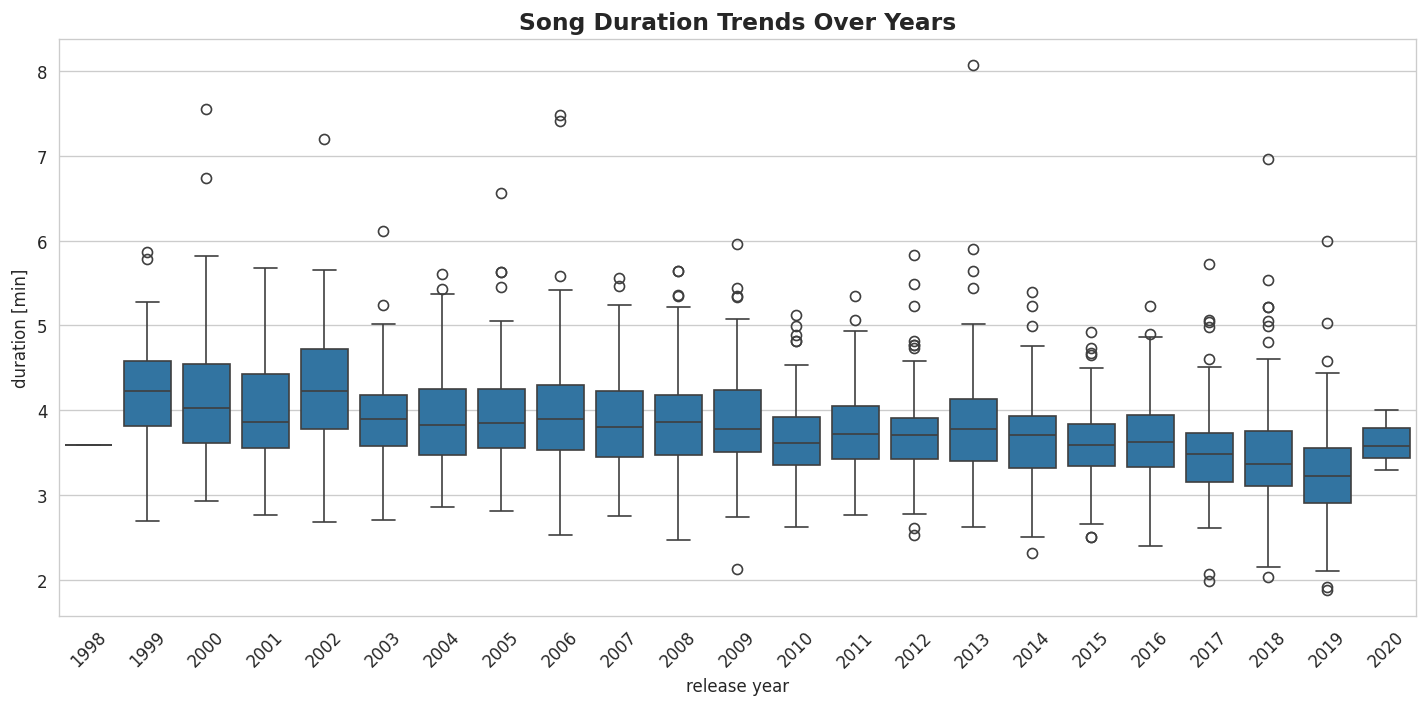

<Figure size 1800x960 with 0 Axes>

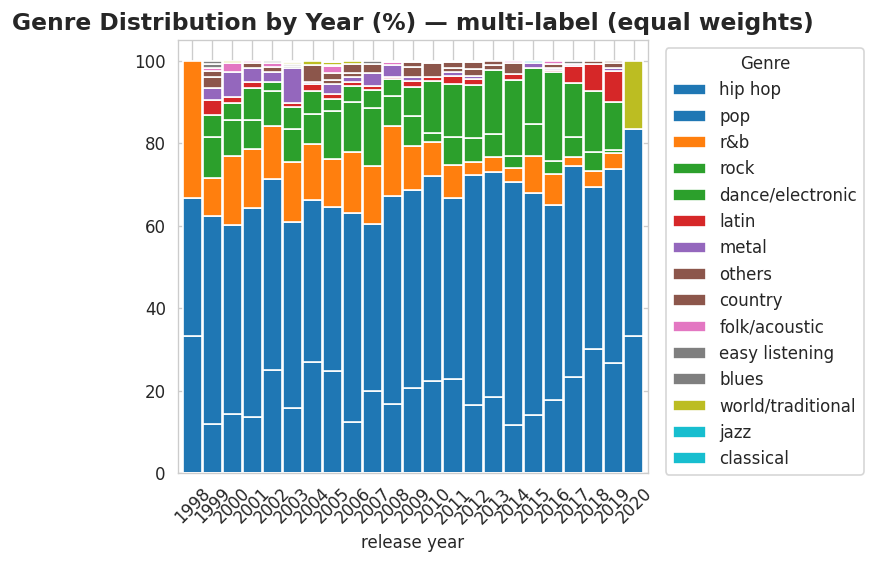

<Figure size 1800x960 with 0 Axes>

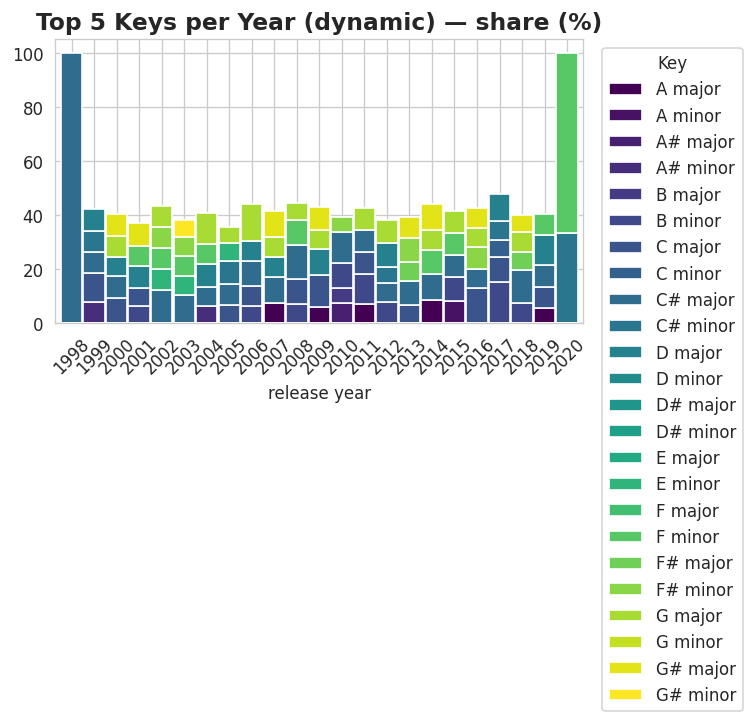

In [57]:
# テンポの年代変化
plt.figure(figsize=(12, 6))
sns.boxplot(data=result_new, x="release year", y="tempo [bpm]")
plt.title("Tempo Trends Over Years", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 楽曲時間の年代変化
plt.figure(figsize=(12, 6))
sns.boxplot(data=result_new, x="release year", y="duration [min]")
plt.title("Song Duration Trends Over Years", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ジャンル分布（多ラベル等分重みで年ごとの割合）
years = sorted(result_new["release year"].dropna().unique().tolist())
genre_year_df = []
for y in years:
    p = multilabel_distribution(result_new.loc[result_new["release year"]==y, "genre_raw"])
    p.name = y
    genre_year_df.append(p)
genre_year = pd.DataFrame(genre_year_df).fillna(0.0)
genre_year.index.name = "release year"
genre_year = (genre_year.T / genre_year.T.sum()).T * 100.0  # 念のため正規化

plt.figure(figsize=(15, 8))
genre_year.plot(kind="bar", stacked=True, colormap="tab10", width=0.95)
plt.title("Genre Distribution by Year (%) — multi-label (equal weights)", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", ncol=1, title="Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# キー分布（各年の上位5キーを動的選出）
key_year = pd.crosstab(result_new["release year"], result_new["key_full"], normalize="index") * 100.0
# 各年ごとに上位5キー以外をゼロにマスク
key_year_masked = key_year.copy()
for y in key_year.index:
    top5 = key_year.loc[y].sort_values(ascending=False).head(5).index
    drop_cols = [c for c in key_year.columns if c not in top5]
    key_year_masked.loc[y, drop_cols] = 0.0

plt.figure(figsize=(15, 8))
key_year_masked.plot(kind="bar", stacked=True, colormap="viridis", width=0.95)
plt.title("Top 5 Keys per Year (dynamic) — share (%)", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", ncol=1, title="Key")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
print("=== 統計的分析：2000年代 vs 2010年代 ===\n")

# 年代で分割
tempo_2000s = result_new.loc[result_new["release year"] <= 2009, "tempo [bpm]"].dropna()
tempo_2010s = result_new.loc[result_new["release year"] >= 2010, "tempo [bpm]"].dropna()
dur_2000s   = result_new.loc[result_new["release year"] <= 2009, "duration [min]"].dropna()
dur_2010s   = result_new.loc[result_new["release year"] >= 2010, "duration [min]"].dropna()

def print_mean_std(label, a, b, unit):
    m0, s0 = np.mean(a), np.std(a, ddof=1)
    m1, s1 = np.mean(b), np.std(b, ddof=1)
    sd_change = (s1 - s0) / s0 * 100.0
    mean_change = (m1 - m0) / m0 * 100.0
    print(f"{label}：")
    print(f"  2000s: {m0:.2f} {unit} (σ={s0:.2f})")
    print(f"  2010s: {m1:.2f} {unit} (σ={s1:.2f})")
    print(f"  平均変化: {mean_change:+.1f}% / 標準偏差変化: {sd_change:+.1f}%")

# 記述統計
print_mean_std("テンポ", tempo_2000s, tempo_2010s, "BPM")
print_mean_std("楽曲時間", dur_2000s, dur_2010s, "min")

# 検定（Welch t, Levene, KS）と効果量
def test_and_effect(name, a, b):
    t_res = st.ttest_ind(a, b, equal_var=False)   # Welch t
    l_res = st.levene(a, b, center="median")      # 分散の等質性
    ks_res = st.ks_2samp(a, b, alternative="two-sided", method="auto")
    d = cohens_d(a, b)

    print(f"\n[{name}]")
    print(f"  Welch t-test: t={t_res.statistic:.3f}, p={t_res.pvalue:.3e}")
    print(f"  Levene test : W={l_res.statistic:.3f}, p={l_res.pvalue:.3e}")
    print(f"  KS test     : D={ks_res.statistic:.3f}, p={ks_res.pvalue:.3e}")
    print(f"  Cohen's d   : {d:.3f}")

test_and_effect("テンポ", tempo_2000s, tempo_2010s)
test_and_effect("楽曲時間", dur_2000s, dur_2010s)

# 7-3) ジャンル多様性（Shannon）：多ラベル重みで年代別に算出し、支持集合固定
p_genre_2000s = multilabel_distribution(result_new.loc[result_new["release year"]<=2009, "genre_raw"])
p_genre_2010s = multilabel_distribution(result_new.loc[result_new["release year"]>=2010, "genre_raw"])
H0, H1, dH, support = shannon_diversity_fixed_support(p_genre_2000s, p_genre_2010s, base=2)
print("\nジャンル多様性（Shannon, base=2）")
print(f"  2000s: {H0:.3f}, 2010s: {H1:.3f}, 変化: {dH:+.1f}%")

# 7-4) キー集中度（HHI）：key_full で算出
key_2000s = result_new.loc[result_new["release year"]<=2009, "key_full"].value_counts(normalize=True)
key_2010s = result_new.loc[result_new["release year"]>=2010, "key_full"].value_counts(normalize=True)
hhi_2000s = (key_2000s**2).sum()
hhi_2010s = (key_2010s**2).sum()
hhi_change = (hhi_2010s - hhi_2000s) / hhi_2000s * 100.0
print("\nキー集中度（HHI）")
print(f"  2000s: {hhi_2000s:.3f} → 2010s: {hhi_2010s:.3f} ({hhi_change:+.1f}%)")

print("\n" + "="*60 + "\n")


=== 統計的分析：2000年代 vs 2010年代 ===

テンポ：
  2000s: 118.47 BPM (σ=28.15)
  2010s: 121.70 BPM (σ=25.70)
  平均変化: +2.7% / 標準偏差変化: -8.7%
楽曲時間：
  2000s: 4.00 min (σ=0.66)
  2010s: 3.64 min (σ=0.59)
  平均変化: -8.9% / 標準偏差変化: -11.2%

[テンポ]
  Welch t-test: t=-2.673, p=7.571e-03
  Levene test : W=18.004, p=2.305e-05
  KS test     : D=0.103, p=4.583e-05
  Cohen's d   : 0.120

[楽曲時間]
  Welch t-test: t=12.706, p=1.353e-35
  Levene test : W=14.581, p=1.383e-04
  KS test     : D=0.247, p=2.254e-27
  Cohen's d   : -0.570

ジャンル多様性（Shannon, base=2）
  2000s: 2.363, 2010s: 2.126, 変化: -10.0%

キー集中度（HHI）
  2000s: 0.050 → 2010s: 0.050 (-0.4%)




## 4. 考察 <a class="anchor" id="fourth-bullet"></a>

本分析では、Spotify Top 2000 トラック（2000-2019年）の音楽的特徴を多角的に分析し、20年間の音楽トレンドの変遷を明らかにした。以下に主要な知見と考察を述べる。

### 4.1 テンポトレンドの変化と音楽業界への影響

**主要な発見：**
- 人気楽曲のテンポは**125.20 BPMと97.92 BPM**に二峰性の分布を示している
- 2000年代から2010年代にかけて、平均テンポは**118.47 BPMから121.70 BPMへと2.7%上昇**
- 統計的有意性：Welch t検定でp=0.0076（p<0.01）、効果量Cohen's d=0.120（小さい効果）

**考察：**
1. **テンポの二峰性分布**は、異なる音楽ジャンルの特性を反映している可能性が高い。125 BPM周辺はダンス・ポップ系、97 BPM周辺はバラード・R&B系の楽曲が多いと推測される。

2. **微増傾向**は音楽業界のデジタル化と関連している可能性がある。ストリーミング配信の普及により、よりエネルギッシュで注意を引きやすい楽曲が求められるようになったと考えられる。

3. **標準偏差の減少**（-8.7%）は、商業的成功を狙った楽曲制作において、一定のテンポレンジに収束する傾向を示唆している。

### 4.2 楽曲時間の短縮化とメディア消費行動の変化

**主要な発見：**
- 人気楽曲の時間は**3.59分**にピークを持つ
- 2000年代から2010年代にかけて、平均時間は**4.00分から3.64分へと8.9%短縮**
- 高い統計的有意性：p=1.353×10^-35（極めて有意）、効果量Cohen's d=-0.570（中程度の効果）

**考察：**
1. **楽曲の短縮化**は、デジタルメディア時代における消費者の注意持続時間の変化を反映している。特にiPod（2001年発売）以降のデジタル音楽配信の普及が影響していると考えられる。

2. **3.59分のピーク**は、ラジオ放送の制約とストリーミング最適化の妥協点を示している可能性がある。ラジオでは3-4分の楽曲が好まれる一方、ストリーミングでは再生完了率を高めるためにより短い楽曲が有利となる。

3. **標準偏差の減少**（-11.2%）は、商業的成功のための「最適な楽曲長」への収束を示唆している。

### 4.3 ジャンル多様性の減少とメインストリーム化

**主要な発見：**
- ジャンル多様性（Shannon指数）は**2.363から2.126へと10.0%減少**
- ポップとヒップホップが圧倒的な割合を占め、特にヒップホップは2010年代に大幅に増加
- 年代を通じてポップジャンルが安定して高い割合を維持

**考察：**
1. **多様性の減少**は、音楽業界のメインストリーム化とグローバル化を反映している。レコード会社の統合や、全世界で成功しやすいジャンルへの集中が影響していると考えられる。

2. **ヒップホップの台頭**は、2010年代の重要な音楽文化的変化を示している。デジタル制作技術の進歩により、従来より低コストで高品質なヒップホップ楽曲の制作が可能になったことが一因と考えられる。

3. **ポップの持続的優位性**は、商業的成功を重視する音楽業界において、幅広い層にアピールできるポップミュージックの安定した需要を示している。

### 4.4 調性分布の安定性と音楽理論的考察

**主要な発見：**
- キー集中度（HHI）は**0.050で20年間ほぼ変化なし**（-0.4%）
- C major、G majorなどの「使いやすい」キーが継続して人気
- 年代を通じて特定のキーへの極端な集中は見られない

**考察：**
1. **キー分布の安定性**は、音楽理論的制約と実用性が20年間変わらなかったことを示している。楽器の特性（特にギター、ピアノ）による制約や、歌いやすさの観点から、特定のキーが好まれ続けている。

2. **低い集中度**（HHI=0.050）は、音楽的多様性が調性面では維持されていることを示している。これは、ジャンル多様性の減少とは対照的な結果である。

3. **長短調の分布**から、メジャーキーの楽曲が圧倒的に多いことがわかる。これは商業音楽における「明るい」音楽への嗜好を反映していると考えられる。

### 4.5 技術革新と音楽トレンドの相関関係

**観察された現象の背景：**

1. **デジタル化の影響（2000年代前期）**
   - iPod（2001年）、iTunes Store（2003年）の登場により、楽曲単位での購入が主流化
   - 楽曲の「フック」重視により、より短く、キャッチーな構成が求められる

2. **ソーシャルメディア時代（2000年代後期）**
   - YouTube（2005年）、MySpace Musicの普及により、視覚的要素も重要に
   - バイラル性を重視した楽曲制作が増加

3. **ストリーミング革命（2010年代）**
   - Spotify（2008年）、Apple Music（2015年）により、再生数・完走率が重要指標に
   - アルゴリズムによるレコメンデーションが楽曲制作に影響
   - プレイリスト文化の台頭により、特定のBPMレンジへの最適化が進行

### 4.6 総合考察と今後への示唆

**本研究の主要な結論：**

1. **標準化の進行**: 音楽の商業化が進む中で、テンポや楽曲時間において「成功の公式」への収束が観察された。これは創造性とビジネス要求のバランスを示している。

2. **技術決定論的変化**: 楽曲時間の短縮化は、技術プラットフォームの特性が音楽制作に直接影響を与える例である。ストリーミング時代における「30秒ルール」（最初の30秒で聴き手を引きつける必要性）がこの傾向を加速させた。

3. **文化的同質化**: ジャンル多様性の減少は、グローバル市場における文化的同質化の音楽版と解釈できる。一方で、調性の多様性が維持されていることは、音楽の本質的な表現力が保持されていることを示唆している。

**今後の研究課題：**
- 2020年代のTikTok時代における更なる楽曲短縮化の検証
- AIによる楽曲制作が音楽的特徴に与える影響の分析
- 地域別・文化圏別の音楽トレンド差異の比較研究

**音楽業界への示唆：**
データ分析により明らかになったトレンドを踏まえつつも、過度な標準化は音楽の多様性を損なう可能性がある。技術的制約と創造的表現のバランスを取ることが、持続可能な音楽文化の発展に重要である。